In [ ]:
import pandas as pd
from jiwer import wer
from whisper.normalizers import EnglishTextNormalizer
import numpy as np
import matplotlib.pyplot as plt
from g2p_en import G2p
import re
import Levenshtein

In [10]:
g2p = G2p()
normalizer = EnglishTextNormalizer()

def findClosestTranscription(decodedTranscript, phoneticTranscription):
    
    dist = Levenshtein.distance(decodedTranscript, phoneticTranscription)

    return dist

In [14]:
""" Data general WER and PER as rated by humans. Table 5 results."""


xlsxPath = "allTranscripts.xlsx"

df = pd.read_excel(xlsxPath)

generalWER = []
generalPER = []

for column in [2, 3, 4]:

    gtCol  = df.columns[1]
    hypCol = df.columns[column]

    truth = df[gtCol].fillna("").astype(str).tolist()[:400]
    hyp   = df[hypCol].fillna("").astype(str).tolist()[:400]

    WER = []
    for j in range(len(truth)):
        WER.append(wer(normalizer(truth[j]), normalizer(hyp[j])))
    print("Human transcriber", column - 1, " WER:", np.mean(WER))

    phoneTRUTH = []
    for i in range(len(truth)):
        phones = []
        for p in g2p(truth[i]): 
            p = re.sub(r'[0-9]', '', p)   
            if re.match(r'[A-Z]+', p): 
                phones.append(p)
        phoneTRUTH.append(phones)
    phoneHYP = []
    for i in range(len(hyp)):
        phones = []
        for p in g2p(hyp[i]): 
            p = re.sub(r'[0-9]', '', p)   
            if re.match(r'[A-Z]+', p): 
                phones.append(p)
        phoneHYP.append(phones)
    levs = []
    for j in range(len(phoneHYP)):
        levs.append(findClosestTranscription(phoneTRUTH[j], phoneHYP[j])/len(phoneTRUTH[j]))
    print("Human transcriber", column - 1, " PER:", np.mean(levs))
    print(" ")

    generalWER.append(WER)
    generalPER.append(levs)

Human transcriber 1  WER: 0.6509266774891774
Human transcriber 1  PER: 0.4406470826657946
 
Human transcriber 2  WER: 0.5856443903318903
Human transcriber 2  PER: 0.43454125972187796
 
Human transcriber 3  WER: 0.6329958513708513
Human transcriber 3  PER: 0.42935056293724827
 


In [15]:
""" Data ALS WER and PER as rated by humans. Table 5 results."""


xlsxPath = "allTranscripts.xlsx"

df = pd.read_excel(xlsxPath)

alsWER = []
alsPER = []

for column in [8, 9, 10]:

    gtCol  = df.columns[7]
    hypCol = df.columns[column]

    truth = df[gtCol].fillna("").astype(str).tolist()[:60]
    hyp   = df[hypCol].fillna("").astype(str).tolist()[:60]

    WER = []
    for j in range(len(truth)):
        WER.append(wer(normalizer(truth[j]), normalizer(hyp[j])))
    print("Human transcriber", column - 1, " WER:", np.mean(WER))

    phoneTRUTH = []
    for i in range(len(truth)):
        phones = []
        for p in g2p(truth[i]): 
            p = re.sub(r'[0-9]', '', p)   
            if re.match(r'[A-Z]+', p): 
                phones.append(p)
        phoneTRUTH.append(phones)
    phoneHYP = []
    for i in range(len(hyp)):
        phones = []
        for p in g2p(hyp[i]): 
            p = re.sub(r'[0-9]', '', p)   
            if re.match(r'[A-Z]+', p): 
                phones.append(p)
        phoneHYP.append(phones)
    levs = []
    for j in range(len(phoneHYP)):
        levs.append(findClosestTranscription(phoneTRUTH[j], phoneHYP[j])/len(phoneTRUTH[j]))
    print("Human transcriber", column - 7, " PER:", np.mean(levs))
    print(" ")

    alsWER.append(WER)
    alsPER.append(levs)

Human transcriber 7  WER: 0.5269047619047619
Human transcriber 1  PER: 0.36908942268888095
 
Human transcriber 8  WER: 0.5069047619047619
Human transcriber 2  PER: 0.38859621830984054
 
Human transcriber 9  WER: 0.4881746031746032
Human transcriber 3  PER: 0.34760476464539936
 


In [16]:
werAll = np.concatenate([generalWER, alsWER], axis = 1)
perAll = np.concatenate([generalPER, alsPER], axis = 1)

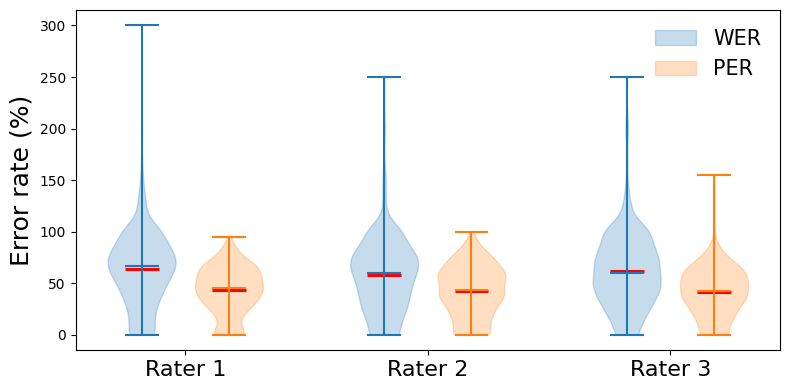

In [18]:
""" Reproduce figure 9. """

wer = werAll.T * 100
per = perAll.T * 100

assert wer.shape == per.shape, f"WER {wer.shape} and PER {per.shape} must match"
nRaters = wer.shape[1]

werByRater = [wer[:, i] for i in range(nRaters)]
perByRater = [per[:, i] for i in range(nRaters)]

centers = np.arange(1, nRaters + 1)
offset = 0.18
posWer = centers - offset
posPer = centers + offset

fig, ax = plt.subplots(figsize = (8, 4))

vpWer = ax.violinplot(werByRater, positions = posWer, widths = 0.28,
                       showmeans = True, showmedians = True)
vpPer = ax.violinplot(perByRater, positions = posPer, widths = 0.28,
                       showmeans = True, showmedians = True)

def styleViolin(vp, color, alpha = 0.25):
    for b in vp['bodies']:
        b.set_facecolor(color)
        b.set_edgecolor(color)
        b.set_alpha(alpha)
    for k in ['cmins', 'cmaxes', 'cbars', 'cmedians']:
        vp[k].set_color(color)
    vp['cmeans'].set_color('red')
    vp['cmeans'].set_linewidth(2.2)

styleViolin(vpWer, color="tab:blue")
styleViolin(vpPer, color="tab:orange")

ax.set_xticks(centers)
ax.set_xticklabels([f"Rater {i+1}" for i in range(nRaters)], fontsize = 16)
ax.set_ylabel("Error rate (%)", fontsize = 18)

from matplotlib.patches import Patch
legendHandles = [
    Patch(facecolor = "tab:blue", edgecolor = "tab:blue", alpha = 0.25, label = "WER"),
    Patch(facecolor = "tab:orange", edgecolor = "tab:orange", alpha = 0.25, label = "PER"),
]
ax.legend(handles = legendHandles, loc = "upper right", frameon = False, fontsize = 15)

plt.tight_layout()
plt.show()